# Vgg16 - flower数据集

【比较Alexnet】卷积层数增多，使用统一的3x3卷积核（可以减少由于层数较多导致的参数量）。准确率提高，运算时间较长

【网络结构】13个卷积，3个全连接
[图片输入(3\*224\*224)] <br>
--> {[卷积+ReLU(64\*224\*224)]
--> {[卷积+ReLU(64\*224\*224)]
--> {[池化(64\*122\*122)]} <br>

--> {[卷积+ReLU(128\*112\*112)]
--> {[卷积+ReLU(128\*112\*112)]
--> {[池化(128\*56\*56)]} <br>

--> {[卷积+ReLU(256\*56\*56)]}
--> {[卷积+ReLU(256\*56\*56)]}
--> {[卷积+ReLU(256\*56\*56)]}
--> {[池化(256\*28\*28)]} <br>

--> {[卷积+ReLU(512\*28\*28)]}
--> {[卷积+ReLU(512\*28\*28)]}
--> {[卷积+ReLU(512\*28\*28)]}
--> {[池化(512\*14\*14)]} <br>

--> {[卷积+ReLU(512\*14\*14)]}
--> {[卷积+ReLU(512\*14\*14)]}
--> {[卷积+ReLU(512\*14\*14)]}
--> {[池化(512\*7\*7)]} <br>

--> {[全连接(512\*7\*7==4096) + ReLU + dropout]} <br>
--> {{[全连接(4096==4096) + ReLU + dropout]} <br>
--> {{[全连接(4096==1000)]}

## 网络训练

### 挂载云盘，使用数据集

In [22]:
from google.colab import drive
drive.mount('/gdrive') ## mount drive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### 加载各种扩展库

In [ ]:
import os
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets, utils
import numpy as np
import torch.optim as optim
from tqdm.notebook import tqdm

### VGG网络准备

#### 官网给出的网络写法

In [ ]:
class VGG(nn.Module):
    def __init__(self, features_seq, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        # 【卷积层+池化层】
        # 因为VGG有好几类，层数又多，不在这里列举了。在后面的函数里，求出层次结构后，传进来
        self.features_seq = features_seq 
        # 全连接层
        self.classifier = nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )
        if init_weights:
            _initialize_weights()

    def forward(self, x):
        # x_size = N x 3 x 224 x 224
        x = self.features_seq (x)

        # x_size = N x 512 x 7 x 7 --> one dimension
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self): # 先沿用官方给出的权重初始化方式，暂时还没有搞明白权重的问题
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

def make_features(cfg: list):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == "M":
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(True)]
            in_channels = v
    return nn.Sequential(*layers) 
    # layers是不同网络层的列表，"*"可以让列表中元素，单个送入nn.Sequential()


cfgs = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def vgg(model_name="vgg16", **kwargs):
    assert model_name in cfgs, "Warning: model number {} not in cfgs dict!".format(model_name)
    cfg = cfgs[model_name]

    model = VGG(make_features(cfg), **kwargs)
    print("yes")
    return model

# "**kwargs" 表示调用函数时，可输入多个数目不定的关键字参数，
# 以字典的形式给出参数，如num_classes=5, init_weights=True

#### 自己一层层写

In [ ]:
class VGG(nn.Module):  
    def __init__(self, num_classes=1000, init_weights=False):
        super(VGG, self).__init__()
        
        self.conv = nn.Sequential( 
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2, stride=2), 

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1), 
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2, stride=2),         
        )

        if init_weights:
            self._initialize_weights()

        self.fc = nn.Sequential(
            nn.Linear(in_features=512*7*7, out_features=4096), 
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            
            nn.Linear(4096, num_classes),
        )

    def forward(self, img):
        feature = self.conv(img)
        feature = torch.flatten(feature, start_dim=1)
        output = self.fc(feature) # 压成一维的形式，送入全连接层
        return output
    
    def _initialize_weights(self): # 先沿用官方给出的权重初始化方式，暂时还没有搞明白权重的问题
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

### 设置网络函数，参数

In [ ]:
# 打印现在正在用的cpu/gpu
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print("using {} device.".format(DEVICE))

# 训练次数
EPOCHS = 30 

# 构建模型
# model = vgg(model_name="vgg16", num_classes=5, init_weights=True).to(DEVICE)
model =  VGG(num_classes=5, init_weights=True).to(DEVICE)

# 定义损失函数
criterion = nn.CrossEntropyLoss() 

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.0001)

using cuda device.


### 准备训练集，验证集
（数据集已提前分好类）

In [ ]:
# 从PIL图像 --> Tensor 
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(
                                      (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                  ]),
    "val": transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(
                                    (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])}
# 数据集的位置
file = '/gdrive/My Drive/Pytorch/flower_data/' 

# train_load 设置
train_dataset = datasets.ImageFolder(root=file+"train",
                                     transform=data_transform["train"])
train_num = len(train_dataset)
batch_size = 32

# number of workers[暂时理解为可以加快速度，但内存消耗大]
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=nw)

# Validate_load 设置
validate_dataset = datasets.ImageFolder(root=file+"val",
                                        transform=data_transform["val"])
val_num = len(validate_dataset)
validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                              batch_size=batch_size, 
                                              shuffle=False,
                                              num_workers=nw)

print("using {} images for training, {} images for validation.".format(train_num,
                                                                        val_num))

Using 2 dataloader workers every process
using 3306 images for training, 364 images for validation.


### 创建json文件，用于图像预测

In [ ]:
# {'daisy':0, 'dandelion':1, 'roses':2, 'sunflower':3, 'tulips':4}
flower_list = train_dataset.class_to_idx

# 把key, value交换，因为最后我们给出数字，返回名称
cla_dict = dict((val, key) for key, val in flower_list.items())
# write dict into json file
json_str = json.dumps(cla_dict, indent=4)
with open(file+'class_indices.json', 'w') as json_file:
    json_file.write(json_str)

### 构建训练函数

In [23]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    batch_total_loss = 0.0
    num_batch = len(train_loader) 

    train_bar = tqdm(train_loader) #加载了一个进度条，要用到循环里面去

    for batch_idx, (data, label) in enumerate(train_bar):
        data, label = data.to(DEVICE), label.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        batch_total_loss += loss.item()

        # print statistics
        train_bar.desc = "[train epoch {}] \tloss:{:.3f}".format(epoch+1, loss)
    print('avg_train_loss: %.3f'% (batch_total_loss/num_batch))

### 构建验证函数

In [ ]:
def val(model, device, test_loader, epoch):
    model.eval()
    num_acc = 0.0  # accumulate accurate number / epoch

    with torch.no_grad():
        val_bar = tqdm(validate_loader)
        
        for val_data, val_label in val_bar:
            val_data, val_label = val_data.to(DEVICE), val_label.to(DEVICE)

            outputs = model(val_data)

            # 找到概率最大的下标
            predict_y = torch.max(outputs, dim=1)[1]

            # torch.eq()比较是否相同，返回T/F
            num_acc += torch.eq(predict_y, val_label).sum().item() 

            val_bar.desc = "Validate: "

    val_accurate = num_acc / val_num
    print('[epoch %d] val_accuracy: %.3f' % (epoch + 1, val_accurate))


### 主函数

In [24]:
def main():
    for epoch in range(EPOCHS):
        train(model, DEVICE, train_loader, optimizer, epoch)
        val(model, DEVICE, validate_loader, epoch)
    print('Finished Training')

    # 网络保存
    save_path = '/gdrive/My Drive/Pytorch/VGG16.pth'
    torch.save(model.state_dict(), save_path)

if __name__ == '__main__':  #主函数入口
    main()


avg_train_loss: 1.044



[epoch 1] val_accuracy: 0.582



avg_train_loss: 0.984



[epoch 2] val_accuracy: 0.637



avg_train_loss: 0.928



[epoch 3] val_accuracy: 0.717



avg_train_loss: 0.907



[epoch 4] val_accuracy: 0.703



avg_train_loss: 0.880



[epoch 5] val_accuracy: 0.692



avg_train_loss: 0.872



[epoch 6] val_accuracy: 0.706



avg_train_loss: 0.832



[epoch 7] val_accuracy: 0.684



avg_train_loss: 0.810



[epoch 8] val_accuracy: 0.698



avg_train_loss: 0.809



[epoch 9] val_accuracy: 0.720



avg_train_loss: 0.790



[epoch 10] val_accuracy: 0.728



avg_train_loss: 0.746



[epoch 11] val_accuracy: 0.701



avg_train_loss: 0.745



[epoch 12] val_accuracy: 0.720



avg_train_loss: 0.729



[epoch 13] val_accuracy: 0.720



avg_train_loss: 0.730



[epoch 14] val_accuracy: 0.728



avg_train_loss: 0.683



[epoch 15] val_accuracy: 0.709



avg_train_loss: 0.696



[epoch 16] val_accuracy: 0.745



avg_train_loss: 0.692



[epoch 17] val_accuracy: 0.739



avg_train_loss: 0.648



[epoch 18] val_accuracy: 0.731



avg_train_loss: 0.660



[epoch 19] val_accuracy: 0.734



avg_train_loss: 0.637



[epoch 20] val_accuracy: 0.725



avg_train_loss: 0.637



[epoch 21] val_accuracy: 0.745



avg_train_loss: 0.623



[epoch 22] val_accuracy: 0.725



avg_train_loss: 0.618



[epoch 23] val_accuracy: 0.758



avg_train_loss: 0.583



[epoch 24] val_accuracy: 0.745



avg_train_loss: 0.573



[epoch 25] val_accuracy: 0.742



avg_train_loss: 0.570



[epoch 26] val_accuracy: 0.747



avg_train_loss: 0.586



[epoch 27] val_accuracy: 0.750



avg_train_loss: 0.569



[epoch 28] val_accuracy: 0.766



avg_train_loss: 0.548



[epoch 29] val_accuracy: 0.747



avg_train_loss: 0.558



[epoch 30] val_accuracy: 0.777
Finished Training


## 预测

### 加载扩展库

In [25]:
from PIL import Image
import matplotlib.pyplot as plt

### 输入图像处理

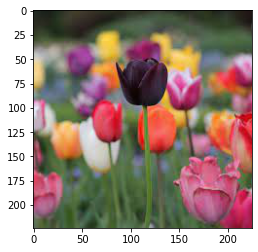

In [26]:
data_transform = transforms.Compose([transforms.Resize((227, 227)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), 
                                                          (0.5, 0.5, 0.5))])
# load image
img_path = '/gdrive/My Drive/Pytorch/flower_data/tulip.jpeg'
assert os.path.exists(img_path), "file: '{}' dose not exist.".format(img_path)
image = Image.open(img_path)
plt.imshow(image)

img = data_transform(image)  # img_tensor_size = C x H x W
# expand batch dimension 在第0个位置 1 x C x H x W, pytorch是按批次处理的
img = torch.unsqueeze(img, dim=0) 

### 给出预测结果

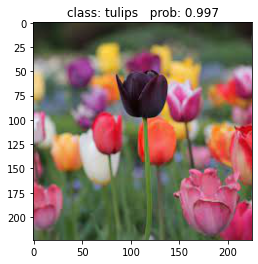

In [31]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 加载网络
model = VGG(num_classes=5, init_weights=True).to(DEVICE)

# load model weights
weights_path =  '/gdrive/My Drive/Pytorch/vgg16/VGG16.pth'
assert os.path.exists(weights_path), "file: '{}' dose not exist.".format(weights_path)
model.load_state_dict(torch.load(weights_path))

# 预测
model.eval()
with torch.no_grad():
    # .cpu()是为了后面用numpy
    # squeeze掉batch dimension
    output = torch.squeeze(model(img.to(DEVICE))).cpu() 
    predict = torch.softmax(output, dim=0) # 给出每一类的概率值
    predict_cla = torch.argmax(predict).numpy() # 找到最大概率值的类

# 加载标签
json_path = '/gdrive/My Drive/Pytorch/flower_data/class_indices.json'
assert os.path.exists(json_path), "file: '{}' dose not exist.".format(json_path)

json_file = open(json_path, "r")
class_indict = json.load(json_file)

# 给出预测结果
print_res = "class: {}   prob: {:.3}".format(class_indict[str(predict_cla)],
                                              predict[predict_cla].numpy())
plt.title(print_res)
plt.imshow(image)